In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


C:\Users\12215\AppData\Local\Temp\ipykernel_26476\1839831674.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("../data/processed/processed_returns.csv")

df["Return_Status"] = df["Return_Status"].astype(int)

y = df["Return_Status"]
X = df.drop(columns=["Return_Status"])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dataset loaded and split.")


Dataset loaded and split.


In [3]:
with open("../results/hyperparameter_tuning_results.json", "r") as f:
    tuning_results = json.load(f)

print("Loaded tuning results:")
tuning_results


Loaded tuning results:


{'Random_Forest': {'best_params': {'max_depth': 20,
   'min_samples_leaf': 1,
   'min_samples_split': 5,
   'n_estimators': 200},
  'best_score': 0.9992761787642711},
 'Gradient_Boosting': {'best_params': {'learning_rate': 0.05,
   'max_depth': 4,
   'n_estimators': 200},
  'best_score': 0.9993377036359036}}

In [4]:
rf_score = tuning_results["Random_Forest"]["best_score"]
gb_score = tuning_results["Gradient_Boosting"]["best_score"]

best_model_name = "Random_Forest" if rf_score >= gb_score else "Gradient_Boosting"
print("BEST MODEL SELECTED:", best_model_name)


BEST MODEL SELECTED: Gradient_Boosting


In [5]:
if best_model_name == "Random_Forest":
    params = tuning_results["Random_Forest"]["best_params"]
    final_model = RandomForestClassifier(**params, class_weight="balanced", random_state=42)
else:
    params = tuning_results["Gradient_Boosting"]["best_params"]
    final_model = GradientBoostingClassifier(**params)


In [6]:
final_model.fit(X_train_scaled, y_train)
print("Final model trained successfully!")


Final model trained successfully!


In [7]:
y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]

final_results = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob)
}

final_results


{'accuracy': 0.9985,
 'precision': 0.9990089197224975,
 'recall': 0.998019801980198,
 'f1': 0.9985141158989599,
 'roc_auc': 0.9987368736873687}

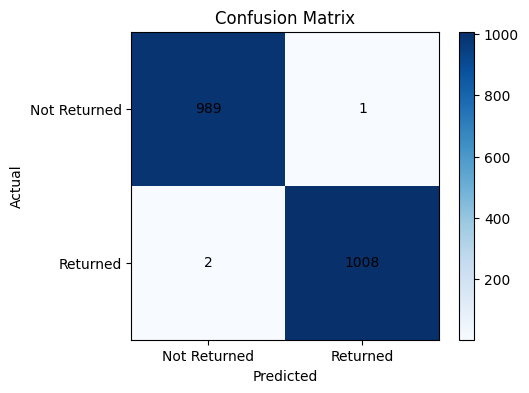

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks([0, 1], ["Not Returned", "Returned"])
plt.yticks([0, 1], ["Not Returned", "Returned"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


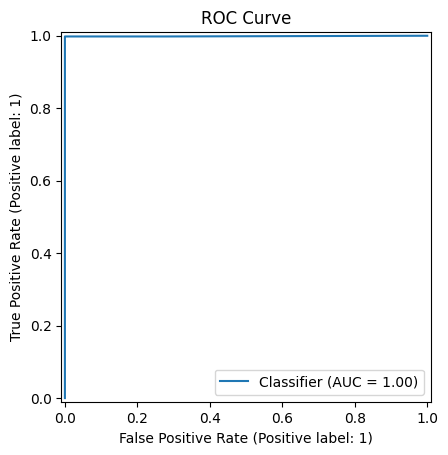

In [9]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve")
plt.show()


In [10]:
save_path = "../results/final_model_evaluation.json"

with open(save_path, "w") as f:
    json.dump(final_results, f, indent=4)

print("Final evaluation saved to:", save_path)


Final evaluation saved to: ../results/final_model_evaluation.json


In [11]:
import pickle

os.makedirs("../models", exist_ok=True)

# Save model
with open("../models/final_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

# Save scaler
with open("../models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save feature order
with open("../models/feature_columns.json", "w") as f:
    json.dump(list(X.columns), f, indent=4)

print("Final model, scaler, and feature list saved.")


Final model, scaler, and feature list saved.
